Import required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans
import folium
from folium.plugins import HeatMap
from sklearn.linear_model import LinearRegression

Load the files

In [38]:
calendar = pd.read_csv('calendar.txt')
routes = pd.read_csv('routes.txt')
trips = pd.read_csv('trips.txt')
stop_times = pd.read_csv('stop_times.txt')
stops = pd.read_csv('stops.txt')
shapes = pd.read_csv('shapes.txt')

Number of Stops per Metro Route

In [39]:
merged = pd.merge(trips, stop_times, on='trip_id')
merged = pd.merge(merged, routes, on='route_id')
stops_per_route = merged.groupby('route_short_name')['stop_id'].nunique().sort_values(ascending=False)
fig = px.bar(x=stops_per_route.index, y=stops_per_route.values,
             labels={'x': 'Route', 'y': 'Number of Stops'}, title='Number of Stops per Metro Route')
fig.show()

Metro Arrival Times by Hour

In [40]:

stop_times['arrival_time'] = pd.to_timedelta(stop_times['arrival_time'], errors='coerce')
stop_times['hour'] = stop_times['arrival_time'].dt.components.hours
fig = px.histogram(stop_times.dropna(subset=['hour']), x='hour', nbins=24,
                   title='Trip Arrival Times Distribution (Hour of Day)', labels={'hour': 'Hour'})
fig.show()


Top 10 Busiest Stations

In [41]:

top_stations = stop_times['stop_id'].value_counts().head(10).reset_index()
top_stations.columns = ['stop_id', 'count']
top_stations = top_stations.merge(stops, on='stop_id')
fig = px.bar(top_stations, y='stop_name', x='count', orientation='h',
             title='Top 10 Busiest Metro Stations', labels={'count': 'Number of Times Appeared'})
fig.update_layout(yaxis={'categoryorder': 'total ascending'})
fig.show()


Predict Busiest Time Window

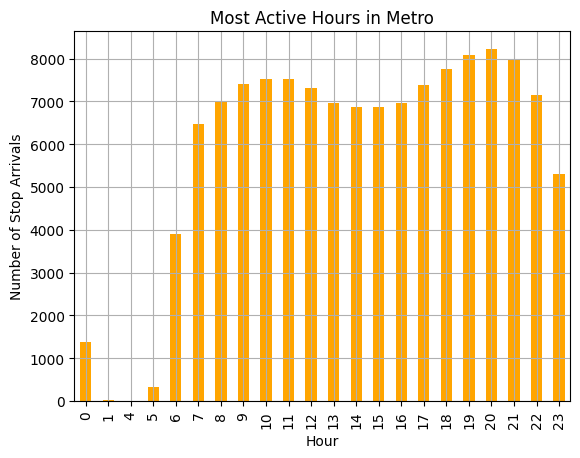

In [51]:
hourly = stop_times.groupby('hour').size()
hourly.plot(kind='bar', color='orange')
plt.title('Most Active Hours in Metro')
plt.xlabel('Hour')
plt.ylabel('Number of Stop Arrivals')
plt.grid(True)
plt.show()

In [42]:
trip_service_counts = trips['service_id'].value_counts().reset_index()
trip_service_counts.columns = ['service_id', 'count']

fig = px.bar(
    trip_service_counts,
    x='service_id',
    y='count',
    labels={'service_id': 'Service Type', 'count': 'Number of Trips'},
    title='Trip Frequency per Service Type'
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()


Hourly Trip Distribution

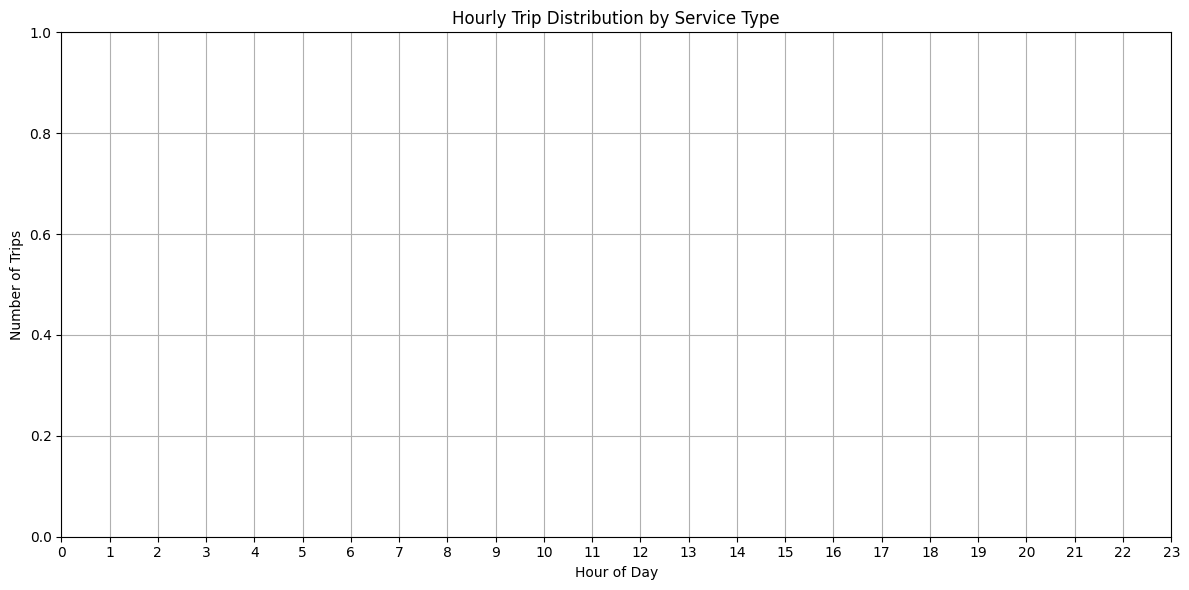

In [43]:
stop_times['arrival_hour'] = pd.to_datetime(
    stop_times['arrival_time'], 
    format='%H:%M:%S', 
    errors='coerce'
).dt.hour

trips_stop_times = pd.merge(trips, stop_times, on='trip_id')
trips_stop_times = trips_stop_times.dropna(subset=['arrival_hour'])

hourly_distribution = trips_stop_times.groupby(['service_id', 'arrival_hour']).size().reset_index(name='trip_count')
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_distribution, x='arrival_hour', y='trip_count', hue='service_id', marker='o')
plt.title('Hourly Trip Distribution by Service Type')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

Headway Analysis

In [44]:
stop_times['arrival_datetime'] = pd.to_timedelta(stop_times['arrival_time'], errors='coerce')
headways = stop_times.sort_values(by=['stop_id', 'arrival_datetime'])
headways['prev_arrival'] = headways.groupby('stop_id')['arrival_datetime'].shift(1)
headways['headway_minutes'] = (headways['arrival_datetime'] - headways['prev_arrival']).dt.total_seconds() / 60

avg_headway = headways.groupby('stop_id')['headway_minutes'].mean().reset_index()
avg_headway = avg_headway.merge(stops[['stop_id', 'stop_name']], on='stop_id')
avg_headway = avg_headway.dropna().sort_values('headway_minutes')

fig = px.bar(
    avg_headway,
    x='stop_name',
    y='headway_minutes',
    title='Average Headway (in Minutes) per Stop',
    labels={'stop_name': 'Stop Name', 'headway_minutes': 'Average Headway (Minutes)'},
)
fig.update_layout(xaxis_tickangle=-45, height=500)
fig.show()

Most Congested Stops

In [45]:
stop_freq = stop_times['stop_id'].value_counts().reset_index()
stop_freq.columns = ['stop_id', 'count']
stop_freq = stop_freq.merge(stops[['stop_id', 'stop_name']], on='stop_id')

top_n = 10
top_stops = stop_freq.head(top_n)

fig = px.bar(
    top_stops,
    x='stop_name',
    y='count',
    title=f'Top {top_n} Most Frequently Served Stops',
    labels={'stop_name': 'Stop Name', 'count': 'Number of Trips'},
)
fig.update_layout(xaxis_tickangle=-45, height=500)
fig.show()

Stop Density Heatmap

In [52]:
# Center the map on the average coordinates of all stops
map_center = [stops['stop_lat'].mean(), stops['stop_lon'].mean()]
metro_map = folium.Map(location=map_center, zoom_start=11)

# Prepare data for the heatmap:
heat_data = [[row['stop_lat'], row['stop_lon']] for _, row in stops.iterrows()]

# Add heatmap to the map
HeatMap(heat_data).add_to(metro_map)

metro_map


Metro Route Map

In [47]:
for shape_id in shapes['shape_id'].unique():
    shape_points = shapes[shapes['shape_id'] == shape_id].sort_values('shape_pt_sequence')
    route_coords = list(zip(shape_points['shape_pt_lat'], shape_points['shape_pt_lon']))
    folium.PolyLine(route_coords, color='blue', weight=2.5, opacity=0.7).add_to(metro_map)

metro_map


Clustering of Stops (KMeans)

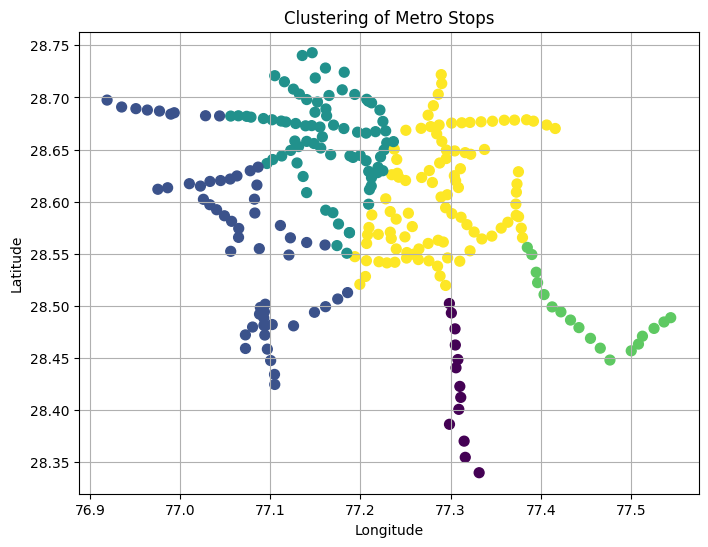

In [48]:
stops_coords = stops[['stop_lat', 'stop_lon']]
kmeans = KMeans(n_clusters=5, random_state=0).fit(stops_coords)
stops['cluster'] = kmeans.labels_
plt.figure(figsize=(8,6))
plt.scatter(stops['stop_lon'], stops['stop_lat'], c=stops['cluster'], cmap='viridis', s=50)
plt.title('Clustering of Metro Stops')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

Predictive Demand Proxy Analysis

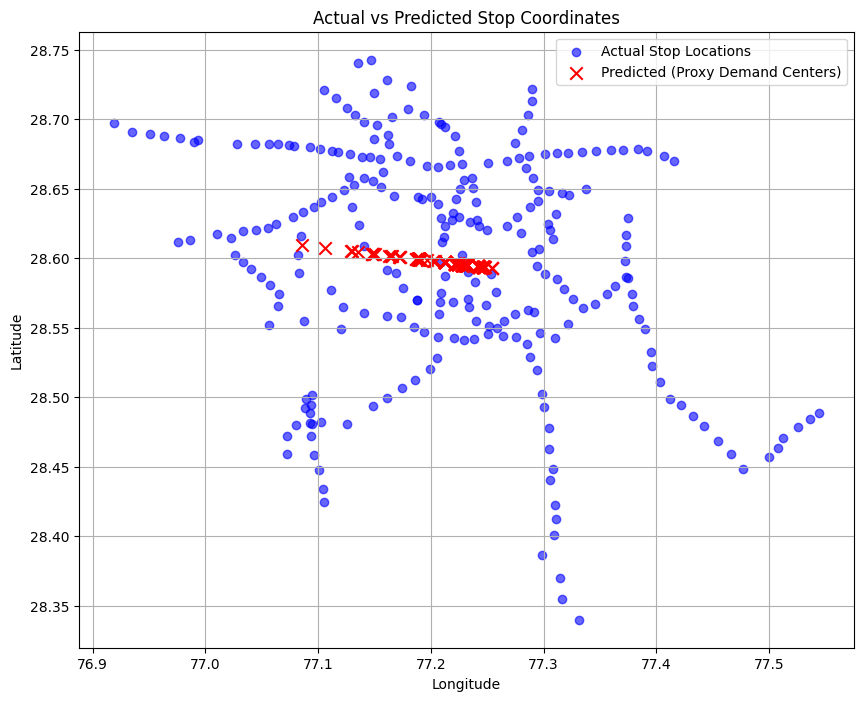

In [49]:
X = stop_freq[['count']]
stop_coords = stops.set_index('stop_id').loc[stop_freq['stop_id']]
Y = stop_coords[['stop_lat', 'stop_lon']]

model = LinearRegression()
model.fit(X, Y)

predicted_coords = model.predict(X)

plt.figure(figsize=(10, 8))

# Actual coordinates
plt.scatter(Y['stop_lon'], Y['stop_lat'], c='blue', label='Actual Stop Locations', alpha=0.6)

# Predicted coordinates
plt.scatter(predicted_coords[:,1], predicted_coords[:,0], c='red', marker='x', label='Predicted (Proxy Demand Centers)', s=80)

plt.title('Actual vs Predicted Stop Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()


In [50]:
# ---- Optimization Suggestions ----
print("\n                       --- Optimization Suggestions ---                           ")
print("1. Increase frequency on routes with high morning (7-10 AM) and evening (5-8 PM) demand.")
print("2. Reduce headways at top congested stops such as:", stop_freq.head(5)['stop_name'].tolist())
print("3. Enhance services on Saturdays and introduce more trips on Sundays to match weekend demand.")
print("4. Focus expansions or feeder services around clustered stop groups.")
print("5. Predictive analysis suggests optimizing around coordinates:", predicted_coords[:3])
print("6. Implement dynamic scheduling: More trains during peak, fewer during off-peak hours.")
print("7. Apply cluster-specific strategies based on stop density and demand patterns.")


                       --- Optimization Suggestions ---                           
1. Increase frequency on routes with high morning (7-10 AM) and evening (5-8 PM) demand.
2. Reduce headways at top congested stops such as: ['Kashmere Gate', 'Rajiv Chowk', 'Central Secretariat', 'Mandi House', 'Qutab Minar']
3. Enhance services on Saturdays and introduce more trips on Sundays to match weekend demand.
4. Focus expansions or feeder services around clustered stop groups.
5. Predictive analysis suggests optimizing around coordinates: [[28.60927955 77.08552156]
 [28.60723499 77.1066145 ]
 [28.60503818 77.12927819]]
6. Implement dynamic scheduling: More trains during peak, fewer during off-peak hours.
7. Apply cluster-specific strategies based on stop density and demand patterns.
